## Part V: Performance Evaluation on Test Dataset of Top Models

In this section, the top CNN, Transformer and SCT models will be evaluated for performance against the hold out test dataset

Performance metrics are:

1.  Precision, Recall, AUC-ROC, Binary Accuracy
2.  Generate AUC-ROC Curves
3.  Generate Confusion Matrices

In [1]:
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras import layers
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay

### Load Dataset

In [3]:
LOAD_FROM_GDRIVE = True

In [4]:
if(LOAD_FROM_GDRIVE):
    # mount google drive to load data
    from google.colab import drive
    drive.mount('/content/drive')

    dataset_root = '/content/drive/MyDrive/Datasets/sepsis/prepared/'

    X_train = np.load(os.path.join(dataset_root, 'X_train.npy'))
    y_train = np.load(os.path.join(dataset_root, 'y_train.npy'))

    X_test = np.load(os.path.join(dataset_root, 'X_test.npy'))
    y_test = np.load(os.path.join(dataset_root, 'y_test.npy'))

    X_val =  np.load(os.path.join(dataset_root, 'X_val.npy'))
    y_val = np.load(os.path.join(dataset_root, 'y_val.npy'))

else:
    # load from datalake (S3)
    !aws s3 cp $s3_datalake_path_prepared $local_data_path_csv --recursive --exclude "*" --include "*.npy"

    X_train = np.load(os.path.join(local_data_path_csv, 'X_train.npy'))
    y_train = np.load(os.path.join(local_data_path_csv, 'y_train.npy'))

    X_test = np.load(os.path.join(local_data_path_csv, 'X_test.npy'))
    y_test = np.load(os.path.join(local_data_path_csv, 'y_test.npy'))

    X_val =  np.load(os.path.join(local_data_path_csv, 'X_val.npy'))
    y_val = np.load(os.path.join(local_data_path_csv, 'y_val.npy'))

Mounted at /content/drive


In [5]:
# refactor targets to work for modeling
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [6]:
# global default parameters
NUM_EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
input_shape = X_train.shape[1:]

# calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.reshape(-1,))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6933899062081287, 1: 1.7927251732101617}

In [7]:
# helper functions for perf eval

# run forward pass and plot confusion matrix
def predict_and_plot_confusion(model, X, y, title):
  y_pred = model.predict(X)
  cm = confusion_matrix(y, np.round(y_pred).tolist())
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  plt.title(title)

# run forward pass and print metrics
def predict_and_print_metrics(model, X, y):
  results = model.evaluate(X, y, batch_size=BATCH_SIZE)
  print(f"Loss: {results[0]}")
  print(f"Binary Accuracy: {results[1]}")
  print(f"Precision: {results[2]}")
  print(f"Recall: {results[3]}")

### Evaluate Best SCT Model on Hold Out Test Data

In [8]:
# load best SCT
best_model_sct = keras.models.load_model('/content/drive/MyDrive/Datasets/sepsis/models/xformer_cnn_tuned.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 514 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step


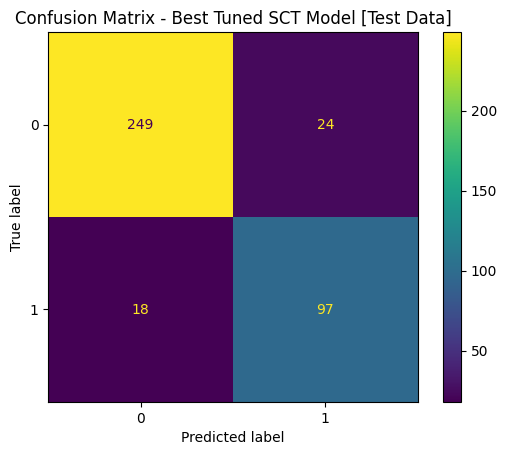

In [9]:
# get metrics for model on val data
predict_and_plot_confusion(best_model_sct, X_test, y_test, "Confusion Matrix - Best Tuned SCT Model [Test Data]")

In [10]:
predict_and_print_metrics(best_model_sct, X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - binary_accuracy: 0.9005 - loss: 0.4883 - precision: 0.7726 - recall: 0.9027
Loss: 0.514836311340332
Binary Accuracy: 0.8917526006698608
Precision: 0.8016529083251953
Recall: 0.843478262424469


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


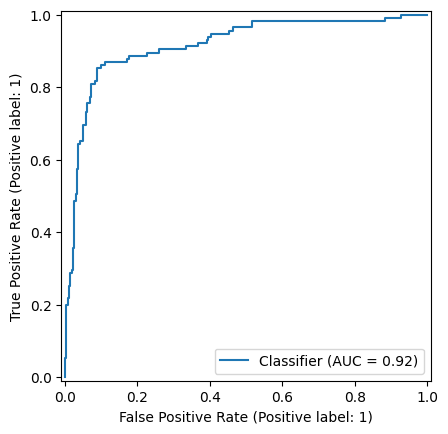

In [11]:
# calc AUC ROC
y_pred_test = best_model_sct.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_test)

### Evaluate Best CNN Model

In [13]:
# load best checkpoint
best_model_cnn = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/sepsis/models/cnn-e1.keras')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


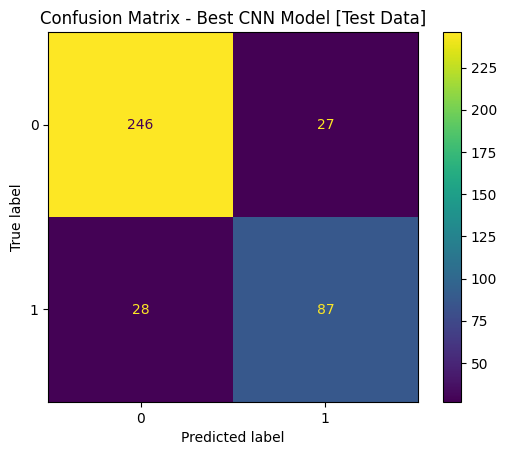

In [14]:
# get metrics for model on val data
predict_and_plot_confusion(best_model_cnn, X_test, y_test, "Confusion Matrix - Best CNN Model [Test Data]")

In [15]:
predict_and_print_metrics(best_model_cnn, X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - binary_accuracy: 0.8759 - f1_score: 0.4240 - loss: 3.7288 - precision_2: 0.7472 - recall_2: 0.8216
Loss: 3.769057512283325
Binary Accuracy: 0.8582473993301392
Precision: 0.7631579041481018
Recall: 0.7565217614173889


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


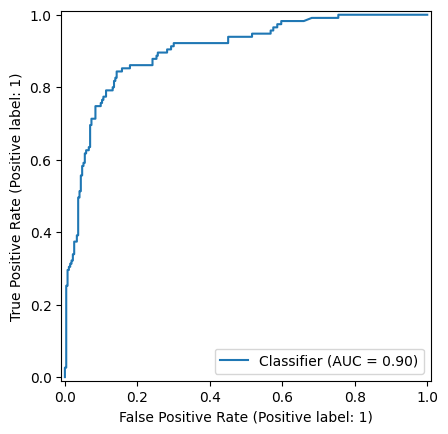

In [16]:
# calc AUC ROC
y_pred_test = best_model_cnn.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_test)

### Evaluate Best Transformer-only Model

In [17]:
# load best checkpoint
best_model_transformer = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/sepsis/models/xformer_baseline.keras')

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step


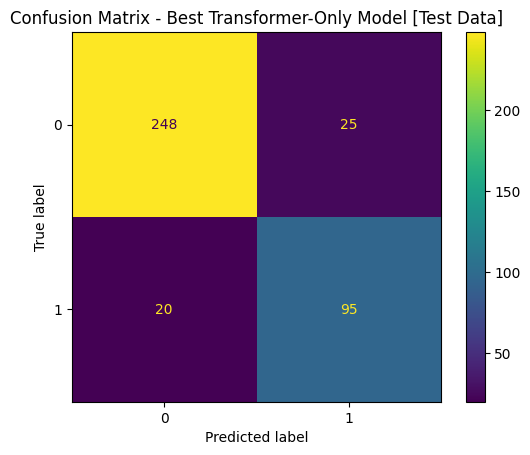

In [19]:
# get metrics for model on val data
predict_and_plot_confusion(best_model_transformer, X_test, y_test, "Confusion Matrix - Best Transformer-Only Model [Test Data]")

In [20]:
predict_and_print_metrics(best_model_transformer, X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - binary_accuracy: 0.8883 - f1_score: 0.4240 - loss: 0.3727 - precision_3: 0.7544 - recall_3: 0.8787
Loss: 0.38648778200149536
Binary Accuracy: 0.8840206265449524
Precision: 0.7916666865348816
Recall: 0.8260869383811951


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


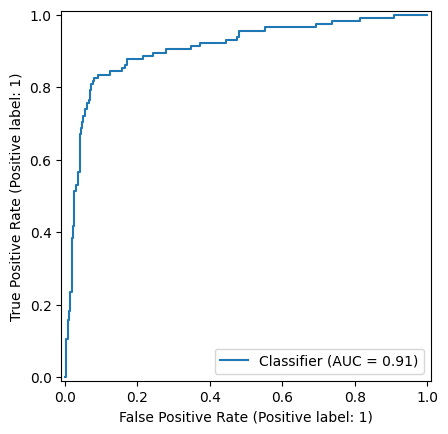

In [21]:
# calc AUC ROC
y_pred_test = best_model_transformer.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred_test)